In [1]:
!pip install pycocotools==2.0.0
!pip install imgaug==0.2.9
!pip uninstall numpy -y
!pip install numpy==1.15.4
!pip install seaborn

You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 757kB 102.7MB/s ta 0:00:01
    100% |████████████████████████████████| 20.4MB 105.3MB/s ta 0:00:016kB 57.0MB/s eta 0:00:0100:01��██████▌                | 9.9MB 93.9MB/s eta 0:00:01/s eta 0:00:01███████████████████████████   | 18.5MB 93.7MB/s eta 0:00:01
    100% |████████████████████████████████| 1.5MB 67.7MB/s ta 0:00:011
  Found existing installation: numpy 1.14.5
    Uninstalling numpy-1.14.5:
      Successfully uninstalled numpy-1.14.5
  Found existing installation: imgaug 0.2.6
    Uninstalling imgaug-0.2.6:
      Successfully uninstalled imgaug-0.2.6
You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Uninstalling numpy-1.17.2:
  Successfully uninstalled numpy-1.17.2
You are using pip version 9.0.1, how

In [2]:
from modelarts.session import Session
session = Session()

bucket_path="ai-awe-001/wabao/data.zip"

    
session.download_data(bucket_path=bucket_path,
                      path='./data.zip')

Successfully download file ai-awe-001/wabao/data.zip from OBS to local ./data.zip


In [3]:
!ls
!unzip data.zip
!ls

*		   output					   test3.jpg
data.zip	   resnet50_weights_tf_dim_ordering_tf_kernels.h5  test.jpg
model1		   test						   training
monkey_labels.txt  test1.jpg					   validation
monky.ipynb	   test2.jpg
Archive:  data.zip
replace validation/n0/n000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
*		   output					   test3.jpg
data.zip	   resnet50_weights_tf_dim_ordering_tf_kernels.h5  test.jpg
model1		   test						   training
monkey_labels.txt  test1.jpg					   validation
monky.ipynb	   test2.jpg


In [4]:
import os
import cv2
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model, load_model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [5]:
training_data = Path('./training/') 
validation_data = Path('./validation/') 
labels_path = Path('./monkey_labels.txt')

labels_info = []

lines = labels_path.read_text().strip().splitlines()[1:]
for line in lines:
    line = line.split(',')
    line = [x.strip(' \n\t\r') for x in line]
    line[3], line[4] = int(line[3]), int(line[4])
    line = tuple(line)
    labels_info.append(line)
    
labels_info = pd.DataFrame(labels_info, columns=['Label', 'Latin Name', 'Common Name', 
                                                 'Train Images', 'Validation Images'], index=None)
print(labels_info.head(10))

labels_dict= {'n0':0, 'n1':1, 'n2':2, 'n3':3, 'n4':4, 'n5':5, 'n6':6, 'n7':7, 'n8':8, 'n9':9}

names_dict = dict(zip(labels_dict.values(), labels_info["Common Name"]))
print(names_dict)

train_df = []
for folder in os.listdir(training_data):
    imgs_path = training_data / folder
    
    imgs = sorted(imgs_path.glob('*.jpg'))
    
    for img_name in imgs:
        train_df.append((str(img_name), labels_dict[folder]))


train_df = pd.DataFrame(train_df, columns=['image', 'label'], index=None)
train_df = train_df.sample(frac=1.).reset_index(drop=True)

valid_df = []
for folder in os.listdir(validation_data):
    imgs_path = validation_data / folder
    imgs = sorted(imgs_path.glob('*.jpg'))
    for img_name in imgs:
        valid_df.append((str(img_name), labels_dict[folder]))

        
valid_df = pd.DataFrame(valid_df, columns=['image', 'label'], index=None)

valid_df = valid_df.sample(frac=1.).reset_index(drop=True)

print("Number of traininng samples: ", len(train_df))
print("Number of validation samples: ", len(valid_df))

print("\n",train_df.head(), "\n")
print("=================================================================\n")
print("\n", valid_df.head())

  Label             Latin Name                Common Name  Train Images  \
0    n0      alouatta_palliata             mantled_howler           131   
1    n1     erythrocebus_patas               patas_monkey           139   
2    n2         cacajao_calvus                bald_uakari           137   
3    n3         macaca_fuscata           japanese_macaque           152   
4    n4        cebuella_pygmea             pygmy_marmoset           131   
5    n5        cebus_capucinus      white_headed_capuchin           141   
6    n6        mico_argentatus           silvery_marmoset           132   
7    n7       saimiri_sciureus     common_squirrel_monkey           142   
8    n8        aotus_nigriceps  black_headed_night_monkey           133   
9    n9  trachypithecus_johnii             nilgiri_langur           132   

   Validation Images  
0                 26  
1                 28  
2                 27  
3                 30  
4                 26  
5                 28  
6            

In [6]:
img_rows, img_cols, img_channels = 224,224,3

# batch size for training  
batch_size=8

# total number of classes in the dataset
nb_classes=10

def get_base_model():
    base_model = ResNet50(input_shape=(img_rows, img_cols, img_channels), weights='imagenet', include_top=True)
    return base_model
base_model = get_base_model()
base_model_output = base_model.layers[-2].output
x = Dropout(0.7,name='drop2')(base_model_output)
output = Dense(10, activation='softmax', name='fc3')(x)
model = Model(base_model.input, output)
for layer in base_model.layers[:-1]:
    layer.trainable=False

optimizer = RMSprop(0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

102858752/102853048 [==============================] - 184s 2us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
________________________________________

In [7]:
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

def data_generator(data, batch_size, is_validation_data=False):
    n = len(data)
    nb_batches = int(np.ceil(n/batch_size))

    indices = np.arange(n)
    batch_data = np.zeros((batch_size, img_rows, img_cols, img_channels), dtype=np.float32)
    batch_labels = np.zeros((batch_size, nb_classes), dtype=np.float32)
    
    while True:
        if not is_validation_data:
            np.random.shuffle(indices)
            
        for i in range(nb_batches):
            next_batch_indices = indices[i*batch_size:(i+1)*batch_size]
            for j, idx in enumerate(next_batch_indices):
                img = cv2.imread(data.iloc[idx]["image"])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                label = data.iloc[idx]["label"]
                
                if not is_validation_data:
                    img = seq.augment_image(img)
                
                img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
                batch_data[j] = img
                batch_labels[j] = to_categorical(label,num_classes=nb_classes)
            
            batch_data = preprocess_input(batch_data)
            yield batch_data, batch_labels

#training data generator 
train_data_gen = data_generator(train_df, batch_size)

# validation data generator 
valid_data_gen = data_generator(valid_df, batch_size, is_validation_data=True)

In [8]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

# checkpoint to save model
chkpt = ModelCheckpoint(filepath="model1", save_best_only=True)

# number of training and validation steps for training and validation
nb_train_steps = int(np.ceil(len(train_df)/batch_size))
nb_valid_steps = int(np.ceil(len(valid_df)/batch_size))

# number of epochs 
# nb_epochs=30

In [10]:
history = model.fit_generator(train_data_gen, 
                              epochs=10, 
                              steps_per_epoch=nb_train_steps, 
                              validation_data=valid_data_gen, 
                              validation_steps=nb_valid_steps,
                              callbacks=[es,chkpt])

Epoch 1/10
137/137 [==============================] - 30s 222ms/step - loss: 0.5858 - acc: 0.8403 - val_loss: 0.5929 - val_acc: 0.8934
Epoch 2/10
137/137 [==============================] - 30s 219ms/step - loss: 0.5219 - acc: 0.8522 - val_loss: 0.4598 - val_acc: 0.9301
Epoch 3/10
137/137 [==============================] - 28s 201ms/step - loss: 0.5744 - acc: 0.8485 - val_loss: 0.7110 - val_acc: 0.8934
Epoch 4/10
137/137 [==============================] - 27s 198ms/step - loss: 0.4583 - acc: 0.8887 - val_loss: 0.4894 - val_acc: 0.9301
Epoch 5/10
137/137 [==============================] - 29s 208ms/step - loss: 0.5641 - acc: 0.8568 - val_loss: 0.2764 - val_acc: 0.9449
Epoch 6/10
137/137 [==============================] - 29s 212ms/step - loss: 0.5488 - acc: 0.8704 - val_loss: 0.4717 - val_acc: 0.9044
Epoch 7/10
137/137 [==============================] - 29s 212ms/step - loss: 0.5255 - acc: 0.8777 - val_loss: 0.3660 - val_acc: 0.9301
Epoch 8/10
137/137 [==============================] - 2

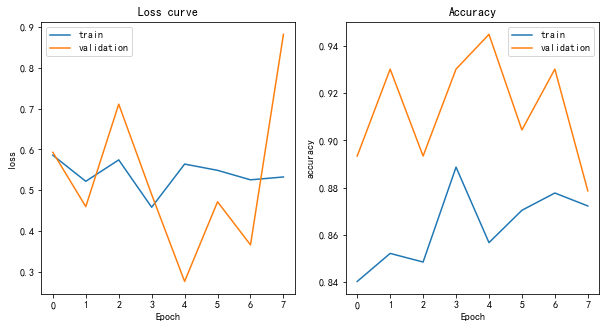

Final validation accuracy: 90.81%


In [11]:
%matplotlib inline

train_acc = history.history['acc']
valid_acc = history.history['val_acc']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

xvalues = np.arange(len(train_acc))

f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues, train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()

valid_loss, valid_acc = model.evaluate_generator(valid_data_gen, steps=nb_valid_steps)
print(f"Final validation accuracy: {valid_acc*100:.2f}%")

In [12]:
outputs = [layer.output for layer in model.layers[1:]]

vis_model = Model(model.input, outputs)

vis_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [13]:
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers going to be used for visualization: ")
print(layer_names)

Layers going to be used for visualization: 
['conv1_pad', 'conv1', 'bn_conv1', 'activation_1', 'max_pooling2d_1', 'res2a_branch2a', 'bn2a_branch2a', 'activation_2', 'res2a_branch2b', 'bn2a_branch2b', 'activation_3', 'res2a_branch2c', 'res2a_branch1', 'bn2a_branch2c', 'bn2a_branch1', 'add_1', 'activation_4', 'res2b_branch2a', 'bn2b_branch2a', 'activation_5', 'res2b_branch2b', 'bn2b_branch2b', 'activation_6', 'res2b_branch2c', 'bn2b_branch2c', 'add_2', 'activation_7', 'res2c_branch2a', 'bn2c_branch2a', 'activation_8', 'res2c_branch2b', 'bn2c_branch2b', 'activation_9', 'res2c_branch2c', 'bn2c_branch2c', 'add_3', 'activation_10', 'res3a_branch2a', 'bn3a_branch2a', 'activation_11', 'res3a_branch2b', 'bn3a_branch2b', 'activation_12', 'res3a_branch2c', 'res3a_branch1', 'bn3a_branch2c', 'bn3a_branch1', 'add_4', 'activation_13', 'res3b_branch2a', 'bn3b_branch2a', 'activation_14', 'res3b_branch2b', 'bn3b_branch2b', 'activation_15', 'res3b_branch2c', 'bn3b_branch2c', 'add_5', 'activation_16', 're

In [47]:
# OUTPUT = 'output'

# if not os.path.exists(OUTPUT):
#     os.mkdir(OUTPUT)

# model.save(os.path.join(OUTPUT, 'model.h5'))

In [14]:
# def get_CAM(processed_image, predicted_label):
#     """
#     This function is used to generate a heatmap for a sample image prediction.
    
#     Args:
#         processed_image: any sample image that has been pre-processed using the 
#                        `preprocess_input()`method of a keras model
#         predicted_label: label that has been predicted by the network for this image
    
#     Returns:
#         heatmap: heatmap generated over the last convolution layer output 
#     """
#     # we want the activations for the predicted label
#     predicted_output = model.output[:, predicted_label]
    
#     # choose the last conv layer in your model
#     last_conv_layer = model.get_layer('res5c_branch2c')
    
#     # get the gradients wrt to the last conv layer
#     grads = K.gradients(predicted_output, last_conv_layer.output)[0]
    
#     # take mean gradient per feature map
#     grads = K.mean(grads, axis=(0,1,2))
    
#     # Define a function that generates the values for the output and gradients
#     evaluation_function = K.function([model.input], [grads, last_conv_layer.output[0]])
    
#     # get the values
#     grads_values, conv_ouput_values = evaluation_function([processed_image])
    
#     # iterate over each feature map in yout conv output and multiply
#     # the gradient values with the conv output values. This gives an 
#     # indication of "how important a feature is"
#     for i in range(2048): # we have 512 features in our last conv layer
#         conv_ouput_values[:,:,i] *= grads_values[i]
    
#     # create a heatmap
#     heatmap = np.mean(conv_ouput_values, axis=-1)
    
#     # remove negative values
#     heatmap = np.maximum(heatmap, 0)
    
#     # normalize
#     heatmap /= heatmap.max()
    
#     return heatmap

True label: 6 
 Predicted label: 6


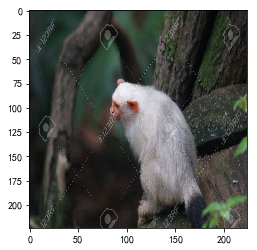

In [27]:
def show_random_sample(idx):
    # select the sample and read the corresponding image and label
    sample_image = cv2.imread(valid_df.iloc[idx]['image'])
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    sample_image = cv2.resize(sample_image, (img_rows, img_cols))
    sample_label = valid_df.iloc[idx]["label"]
    
    # pre-process the image
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    sample_image_processed = preprocess_input(sample_image_processed)
    
    # generate activation maps from the intermediate layers using the visualization model
    activations = vis_model.predict(sample_image_processed)
    
    # get the label predicted by our original model
    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]

    plt.imshow(sample_image)
    print(f"True label: {sample_label} \n Predicted label: {pred_label}")

    plt.show()
    
    return activations

activations= show_random_sample(123)

True label: 4 
 Predicted label: 4


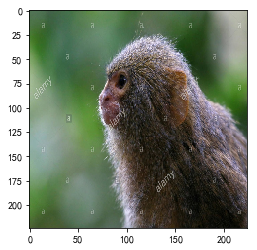

In [36]:
from random import randint
n = randint(1,300)
activations= show_random_sample(n)